# Cuaderno de cálculos y gráficas

In [1]:
# Import modules
import ipywidgets
import numpy as np
import pandas as pd
import importlib
import logging
import glob
import json
import os

# All the stuffs for the processing of MI
import processing as pr

# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

# Signal processing
import scipy.signal as snl
from scipy.io import wavfile
import scipy.stats as stats

# Logging
import logging
logging.disable(logging.CRITICAL)

 2020-11-13 15:07:59,099 - DEBUG - Define classes and functions.
 2020-11-13 15:07:59,102 - DEBUG - Loaded backend module://ipykernel.pylab.backend_inline version unknown.


### File paths

In [2]:
mi_folder = "../Data/mutualinfo/"
mi_files = glob.glob(mi_folder + "ds1/*.mi")
mi_files.sort()
ds8_files = glob.glob(mi_folder + "ds8/*.mi")
ds8_files.sort()

To open the files with the MI data already averaged
```
with open("MI_rel.dat", "r") as f:
    line = f.readline()
    MI_rel = eval(line)
with open("MI_rel_ds8.dat", "r") as f:
    line = f.readline()
    MI_rel_ds8 = eval(line)
    
bands = list(MI_rel.keys())
channels = list(MI_rel["delta"].keys())
```

### Get MI info from files
We've already calculated all the MI values. Now we will take those values and do some statistical calculations on them.

In [3]:
importlib.reload(pr)
cumdata = {}
total = len(mi_files)
current = 0
for file in mi_files:
    data = pr.MutualInformation()
    data.load(file_path = file)
    # name = os.path.split(file)[1].split(".")[0] + "_ds8.mi
    # folder = os.path.split(os.path.split(file)[0])[0] + "/ds8/"
    # path = folder + name
    # datads8 = pr.MutualInformation(1,2,3,4,5,True,path)
    
    try:
        bands
    except NameError:
        bands = list(data.mi.keys())
        channels = list(data.mi[bands[0]].keys()) 
        
    if cumdata == {}:
        for band in bands:
            cumdata[band] = {}
            for channel in channels:
                cumdata[band][channel] = {"face": [], "noface": []}

    for band in bands:
        for channel in channels:
            if data.face_nonscrambled:
                cumdata[band][channel]["face"].append(data.mi[band][channel])
            else:
                cumdata[band][channel]["noface"].append(data.mi[band][channel])
    current += 1
    if current%1000 == 0 or current == total:
        print("Gone through " + str(current/total *100))

### Prepare parametric and non-parametric tests (one way ANOVA and Kruskal-Wallis ANOVA)

In [4]:
fandp_anova = {}
for band in bands:
    fandp_anova[band] = {}
    for channel in channels:
        fandp_anova[band][channel] = stats.f_oneway(cumdata[band][channel]["face"], cumdata[band][channel]["noface"])
fandp_kruskal = {}
for band in bands:
    fandp_kruskal[band] = {}
    for channel in channels:
        fandp_kruskal[band][channel] = stats.kruskal(cumdata[band][channel]["face"], cumdata[band][channel]["noface"])

savefile = open("data.csv", "w")
savefile.write("band, channel, owanova_F, owanova_p, kruskal_F, kruskal_p\n")

for band in bands:
    for channel in channels:
        str0 = str(band) + ", " + str(channel) + ", "
        list1 = list(fandp_anova[band][channel])
        str1 = str(list1[0]) + ", " + str(list1[1]) + ", "
        list2 = list(fandp_kruskal[band][channel])
        str2 = str(list2[0]) + ", " + str(list2[1]) + "\n"
        strend = str0 + str1 + str2
        savefile.write(strend)
        
        #print("--- BAND " + band + " CHANNEL " + channel + " ---")
        #print("OWANOVA: " + str(fandp_anova[band][channel]))
        #print("KRUSKAL: " + str(fandp_kruskal[band][channel]))

NameError: name 'bands' is not defined

In [37]:
vals = [float(value) for value in cumdata["gamma"]["Fpz"]["noface"]]

In [39]:
vals = np.array(vals)
vals = (vals - vals.min())/vals.max()

In [44]:
hist = np.histogram(vals, 4)

In [45]:
hist

(array([  16,   73,  334, 2279]),
 array([0.        , 0.00498854, 0.00997709, 0.01496563, 0.01995417]))

In [ ]:
plt.plot()

## Plotting part

In [ ]:
fig = plt.figure()

bands = list(MI_rel.keys())
k = bands[0]
labels = list(MI_rel[k].keys())
mi_rel_vals = list(MI_rel[k].values())
ds8_rel_vals = list(MI_rel_ds8[k].values())

In [ ]:
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, mi_rel_vals, width, label='No downsampling')
rects2 = ax.bar(x + width/2, ds8_rel_vals, width, label='Downsampling')

ax.set_ylabel('Relative Mutual Information')
ax.set_title('Comparison between downsampled and non-downsampled MI values')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


fig.tight_layout()

plt.show()

In [7]:
paths = glob.glob("../raw_data/Stimuli/*.wav")

In [14]:
tot = 0
cumsum = 0
seconds =[]
for path in paths:
    try:
        fs, data = wavfile.read(path)
        seconds.append(len(data)/fs)
        cumsum += len(data)/fs
        tot += 1
    except:
        continue

/Library/Python/3.7/site-packages/ipykernel_launcher.py:6: WavFileWarning: Chunk (non-data) not understood, skipping it.
  


### Import MI_diff and MI_rel (.dat) and export as .xlsx

This is done to put them nicely in Google sheets and be able to check which ranges of values we are working with

```
midiff = open("./quick_exports/MI_diff.dat", "r")
midiff = eval(midiff.readline())
df = pd.DataFrame(midiff)
df.to_excel("midiff.xlsx")
mirel = open("./quick_exports/MI_rel.dat", "r")
mirel = eval(mirel.readline())
df = pd.DataFrame(mirel)
df.to_excel("mirel.xlsx")
```

## Put the .json files exported from MI_Calculation to .csv

In [3]:
with open("kw.json", "r") as jsonfile:
    kw = json.load(jsonfile)
with open("anova.json", "r") as jsonfile:
    anova = json.load(jsonfile)

In [4]:
csvfile = open("anovakruskal.csv", "w")
for band in kw.keys():
    for channel in kw[band].keys():
        kwf, kwp = kw[band][channel]
        anovaf, anovap = anova[band][channel]
        print_string = ",".join([band, channel, str(kwf), str(kwp), str(anovaf), str(anovap), "\n"])
        csvfile.write(print_string)
        
csvfile.close()
        

### Let's do a Kolmogorov-Smirnov test

In [3]:
with open("cumdata.json", "r") as jsonfile:
    cumdata = json.load(jsonfile)

In [25]:
len(cumdata["delta"]["Fp1"]["face"])

2704

In [11]:
csvfile = open("kstest.csv", "w")
for band in cumdata.keys():
    for channel in cumdata[band].keys():
        for state in cumdata[band][channel].keys():
            data = cumdata[band][channel][state]
            hist, bin_edges = np.histogram(data, int(np.ceil(len(data)/100)))
            
            
            
            
            ks_stats, p_value = stats.kstest(np.abs(), 'norm')
            print_string = ",".join([band, channel, str(ks_stats), str(p_value), "\n"])
            csvfile.write(print_string)
            
csvfile.close()

In [36]:
data = cumdata["theta_high"]["Fp1"]["noface"]
hist, bin_edges = np.histogram(data, int(np.ceil(len(data)/100)))
values = []
for i in range(len(hist)):
    values.append([hist[i], (bin_edges[i]+bin_edges[i+1])/2])

In [37]:
data = np.hstack([np.repeat(x, int(f)) for f,x in values])
loc, scale = stats.norm.fit(data)
n = stats.norm(loc=loc, scale=scale)

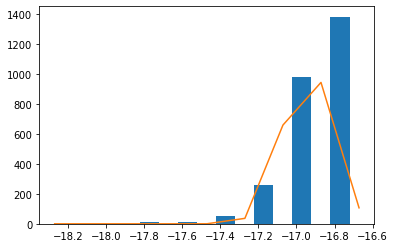

In [38]:
plt.hist(data, bins=np.arange(data.min(), data.max()+0.2, 0.2), rwidth=0.5)
x = np.arange(data.min(), data.max()+0.2, 0.2)
plt.plot(x, 350*n.pdf(x))
plt.show()

In [39]:
stats.kstest(data, n.cdf)

KstestResult(statistic=0.281805761463791, pvalue=8.336727664930047e-187)

In [35]:
cumdata["theta_high"]["Fp1"].keys()

dict_keys(['face', 'noface'])